## Information Plane Analysis

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pickle

from estimators.knn_estimators import calc_ksg_mi_cc, calc_ksg_mi_cd
from estimators.neural_estimators import calc_neural_mi

2024-07-01 15:03:12.613306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 15:03:12.613369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 15:03:12.615083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 15:03:12.623332: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load and Preprocess Dataset

In [2]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def onehot_encode(image, label, n_classes):
    label = tf.one_hot(label, depth=n_classes)
    return image, label

(ds_train, ds_test), ds_info = tfds.load('mnist',
                                         split=['train', 'test'],
                                         data_dir = '../tensorflow_datasets/',
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True,)
n_classes = ds_info.features['label'].num_classes
ds_train = ds_train.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(256).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(256).cache().prefetch(tf.data.AUTOTUNE)

2024-07-01 15:03:30.453714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78823 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


### Create and Train Model

In [42]:
model = tf.keras.Sequential()
model.add(Flatten(input_shape=(ds_train.element_spec[0].shape[1:])))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(ds_train.element_spec[1].shape[1], activation='linear'))

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

train_loss, train_acc = model.evaluate(ds_train)
test_loss, test_acc = model.evaluate(ds_test)

all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

model.save('../results/Information_Bottleneck/saved_models/epoch_00.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../results/Information_Bottleneck/saved_models/epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(ds_train, verbose=1, epochs=50, validation_data=ds_test, callbacks=[model_checkpoint_callback])

all_train_loss.extend(history.history['loss'])
all_train_acc.extend(history.history['accuracy'])
all_test_loss.extend(history.history['val_loss'])
all_test_acc.extend(history.history['val_accuracy'])

40/40 [==============================] - 0s 1ms/step - loss: 2.3223 - accuracy: 0.0572
Epoch 1/50
212/235 [==========================>...] - ETA: 0s - loss: 0.4176 - accuracy: 0.8805
Epoch 1: saving model to ../results/Information_Bottleneck/saved_models/epoch_01.keras
235/235 [==============================] - 2s 3ms/step - loss: 0.3960 - accuracy: 0.8867 - val_loss: 0.1678 - val_accuracy: 0.9491
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9579
Epoch 2: saving model to ../results/Information_Bottleneck/saved_models/epoch_02.keras
235/235 [==============================] - 1s 3ms/step - loss: 0.1434 - accuracy: 0.9579 - val_loss: 0.1239 - val_accuracy: 0.9614
Epoch 3/50
211/235 [=========================>....] - ETA: 0s - loss: 0.1015 - accuracy: 0.9699
Epoch 3: saving model to ../results/Information_Bottleneck/saved_models/epoch_03.keras
235/235 [==============================] - 1s 3ms/step - loss: 0.1000 - accuracy: 0.9706 - val_loss: 0

Text(0, 0.5, 'Accuracy')

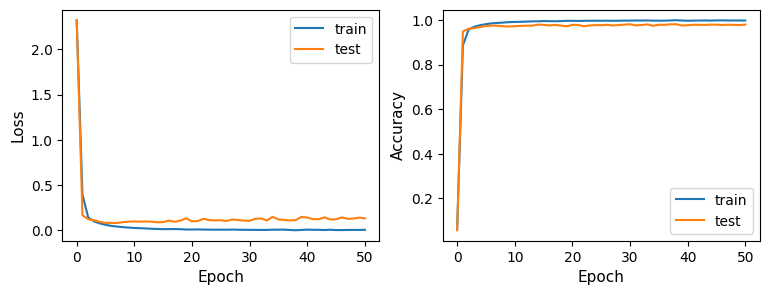

In [67]:
fig, axs =  plt.subplots(1, 2, figsize=(9, 3), dpi=100)
axs[0].plot(range(51), all_train_loss, c='tab:blue', label='train')
axs[0].plot(range(51), all_test_loss, c='tab:orange', label='test')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[1].plot(range(51), all_train_acc, c='tab:blue', label='train')
axs[1].plot(range(51), all_test_acc, c='tab:orange', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].set_ylabel('Accuracy', fontsize=11)
plt.show()

### Compute MI

In [5]:
mi_ty_ksg = []
mi_xt_ksg = []

x_list = []
y_list = []
# for x, y in ds_train:
#     x_list.extend(x.numpy())
#     y_list.extend(y.numpy())
for x, y in ds_test:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())

for epoch in range(51):
    model = tf.keras.models.load_model(f"../results/Information_Bottleneck/saved_models/epoch_{epoch:02d}.keras")
    int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    activity = int_model.predict(np.array(x_list), verbose=0, batch_size=256)
    mi_ty_ksg.append(calc_ksg_mi_cd(x=activity, y=np.squeeze(y_list)))
    mi_xt_ksg.append(calc_ksg_mi_cc(x=np.reshape(x_list, (len(x_list),-1)), y=activity))
    print(f'{epoch:02}/50: I(T;Y)={mi_ty_ksg[-1]:.3f}, I(X;T)={mi_xt_ksg[-1]:.3f}')

00/51: I(T;Y)=1.873, I(X;T)=0.004
01/51: I(T;Y)=0.673, I(X;T)=1.593
02/51: I(T;Y)=1.107, I(X;T)=1.372
03/51: I(T;Y)=1.276, I(X;T)=1.143
04/51: I(T;Y)=1.358, I(X;T)=0.969
05/51: I(T;Y)=1.418, I(X;T)=0.808
06/51: I(T;Y)=1.447, I(X;T)=0.730
07/51: I(T;Y)=1.470, I(X;T)=0.687
08/51: I(T;Y)=1.498, I(X;T)=0.633
09/51: I(T;Y)=1.501, I(X;T)=0.589
10/51: I(T;Y)=1.539, I(X;T)=0.540
11/51: I(T;Y)=1.581, I(X;T)=0.510
12/51: I(T;Y)=1.590, I(X;T)=0.491
13/51: I(T;Y)=1.556, I(X;T)=0.463
14/51: I(T;Y)=1.554, I(X;T)=0.448
15/51: I(T;Y)=1.557, I(X;T)=0.438
16/51: I(T;Y)=1.578, I(X;T)=0.401
17/51: I(T;Y)=1.578, I(X;T)=0.399
18/51: I(T;Y)=1.602, I(X;T)=0.374
19/51: I(T;Y)=1.580, I(X;T)=0.340
20/51: I(T;Y)=1.612, I(X;T)=0.317
21/51: I(T;Y)=1.623, I(X;T)=0.312
22/51: I(T;Y)=1.619, I(X;T)=0.291
23/51: I(T;Y)=1.621, I(X;T)=0.275
24/51: I(T;Y)=1.602, I(X;T)=0.239
25/51: I(T;Y)=1.565, I(X;T)=0.267
26/51: I(T;Y)=1.618, I(X;T)=0.211
27/51: I(T;Y)=1.641, I(X;T)=0.207
28/51: I(T;Y)=1.618, I(X;T)=0.188
29/51: I(T;Y)=

In [43]:
results = {}
results['mi_ty_ksg'] = mi_ty_ksg
results['mi_xt_ksg'] = mi_xt_ksg

with open(f"../results/Information_Bottleneck/mi_ksg", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

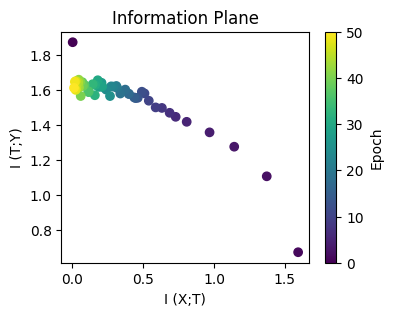

In [27]:
with open('../results/Information_Bottleneck/mi_ksg', 'rb') as f:
    results = pickle.load(f)

mi_ty_ksg = results['mi_ty_ksg']
mi_xt_ksg = results['mi_xt_ksg']

plt.figure(figsize=(4,3), dpi=100)
plt.scatter(mi_xt_ksg, mi_ty_ksg, c=range(51))
plt.colorbar(orientation='vertical', label='Epoch')
plt.xlabel('I (X;T)')
plt.ylabel('I (T;Y)')
plt.title('Information Plane')
plt.show()

In [22]:
mi_ty_neural = []
mi_xt_neural = []

x_list = []
y_list = []
for x, y in ds_train:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())
for x, y in ds_test:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())
    
x_tensor = tf.convert_to_tensor(np.reshape(x_list, (len(x_list),-1)))
y_tensor = tf.convert_to_tensor(np.squeeze(y_list))

for epoch in range(51):
    model = tf.keras.models.load_model(f"../results/Information_Bottleneck/saved_models/epoch_{epoch:02d}.keras")
    int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    activity = int_model.predict(np.array(x_list), verbose=0, batch_size=256)
    activity_tensor = tf.convert_to_tensor(activity)
    dataset_ty = tf.data.Dataset.from_tensor_slices((activity_tensor, y_tensor)).batch(256)
    mi_ty_neural.append(calc_neural_mi(dataset_ty, n_epochs=200, critic='concat', train_obj='js_fgan', eval_type='smile', print_mi=False, alpha=1.0, clip=5.0))
    dataset_xt = tf.data.Dataset.from_tensor_slices((x_tensor, activity_tensor)).batch(256)
    mi_xt_neural.append(calc_neural_mi(dataset_xt, n_epochs=200, critic='concat', train_obj='js_fgan', eval_type='smile', print_mi=False, alpha=1.0, clip=5.0))
    print(f'{epoch:02}/50: I(T;Y)={mi_ty_neural[-1]:.3f}, I(X;T)={mi_xt_neural[-1]:.3f}')

00/50: I(T;Y)=1.932, I(X;T)=9.820
01/50: I(T;Y)=2.178, I(X;T)=9.977
02/50: I(T;Y)=2.191, I(X;T)=9.535
03/50: I(T;Y)=2.201, I(X;T)=9.851
04/50: I(T;Y)=2.227, I(X;T)=9.901
05/50: I(T;Y)=2.220, I(X;T)=8.764
06/50: I(T;Y)=2.225, I(X;T)=9.710
07/50: I(T;Y)=2.244, I(X;T)=9.774
08/50: I(T;Y)=2.248, I(X;T)=9.899
09/50: I(T;Y)=2.263, I(X;T)=9.731
10/50: I(T;Y)=2.258, I(X;T)=9.790
11/50: I(T;Y)=2.250, I(X;T)=8.931
12/50: I(T;Y)=2.259, I(X;T)=9.555
13/50: I(T;Y)=2.268, I(X;T)=9.553
14/50: I(T;Y)=2.266, I(X;T)=9.652
15/50: I(T;Y)=2.258, I(X;T)=9.086
16/50: I(T;Y)=2.241, I(X;T)=9.136
17/50: I(T;Y)=2.262, I(X;T)=8.469
18/50: I(T;Y)=2.238, I(X;T)=8.902
19/50: I(T;Y)=2.261, I(X;T)=9.608
20/50: I(T;Y)=2.270, I(X;T)=8.127
21/50: I(T;Y)=2.269, I(X;T)=8.288
22/50: I(T;Y)=2.248, I(X;T)=9.527
23/50: I(T;Y)=2.265, I(X;T)=7.869
24/50: I(T;Y)=2.267, I(X;T)=8.294
25/50: I(T;Y)=2.275, I(X;T)=8.096
26/50: I(T;Y)=2.262, I(X;T)=7.425
27/50: I(T;Y)=2.265, I(X;T)=8.126
28/50: I(T;Y)=2.262, I(X;T)=7.257
29/50: I(T;Y)=

In [23]:
results = {}
results['mi_ty_neural'] = mi_ty_neural
results['mi_xt_neural'] = mi_xt_neural

with open(f"../results/Information_Bottleneck/mi_neural", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

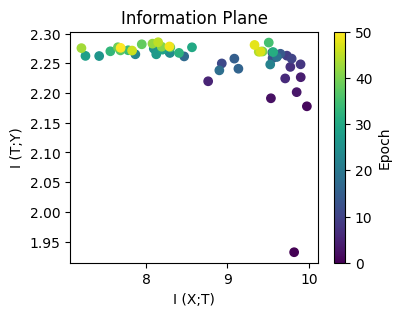

In [26]:
with open('../results/Information_Bottleneck/mi_neural', 'rb') as f:
    results = pickle.load(f)

mi_ty_neural = results['mi_ty_neural']
mi_xt_neural = results['mi_xt_neural']

plt.figure(figsize=(4,3), dpi=100)
plt.scatter(mi_xt_neural, mi_ty_neural, c=range(51))
plt.colorbar(orientation='vertical', label='Epoch')
plt.xlabel('I (X;T)')
plt.ylabel('I (T;Y)')
plt.title('Information Plane')
plt.show()